In [1]:
import sys
sys.path.append('../../preLIMinary/')
sys.path.append('/home/gsatopo1/library/lim')
from lim import lim
import numpy as np
import astropy.units as u
import astropy.constants as cu
from LIM_lightcone import paint_lightcone, make_survey, make_measurements
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d, RegularGridInterpolator

import pysm3
import healpy as hp
import time
from mpi4py import MPI
from scipy import integrate
import matplotlib
from mpl_toolkits.axes_grid1 import make_axes_locatable

LC_path='/home/gsatopo1/data-mkamion1/MDPL2-UM-squareLC/'

grey='#263240'
dark_blue='#324356'
turquoise='#54858a'
yellow='#f0db92'
yellow_orange='#edc080'
orange='#C37854'
cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", [dark_blue,turquoise,yellow,yellow_orange,orange])

palette=['#1a4b6e', '#d4a95b', '#b3592e', '#3c651e', '#9B88B5', '#5f685f']
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=palette)
plt.rcParams['figure.figsize'] = [8, 6]
plt.rcParams['font.size'] = 16
plt.rcParams['lines.linewidth'] = 2.5
plt.rcParams['axes.linewidth'] = 1.5

### Survey parameters
We generate lightcones with the following parameters

|Redshifts|$\Omega$ (deg$^2$)|$\theta_{\rm FWHM}$ (arcmin)|R|
|---|---|---|---|
|2.5-3.5|400|2|700|

In [2]:
def LC_params(line):
    h=0.678

    ang_lim=1*u.deg
    model_params=dict(halo_lightcone_dir=LC_path, 
                      do_external_SFR = False, external_SFR = '',
                      SFR_pars=dict(),
                      resampler='cic',
                      angular_supersample=1,
                      spectral_supersample=1,
                      do_downsample=False,
                      cube_mode='flat_sky',
                      Nmu=20,
                      kmax=2*u.Mpc**-1,
                      dk=0.02*u.Mpc**-1,
                      seed=0)
    obs_params=dict(RAObs_min=-ang_lim,RAObs_max=ang_lim, DECObs_min=-ang_lim,DECObs_max=ang_lim,
                    RA_min=-ang_lim,RA_max=ang_lim, DEC_min=-ang_lim,DEC_max=ang_lim,
                    Nfeeds=1000, beam_FWHM=2*u.arcmin, tobs=6000*u.hr, 
                    do_angular_smooth=True, do_spectral_smooth=True)
    
    if line=='CO':
        nu_CO=115.271*u.GHz
        zmin = 2.5;zmax = 2.51
        zmid=(zmax+zmin)/2
        R=700
        dnu=nu_CO/(1+zmid)/R
        nuObs_max=nu_CO/(1+zmin); nuObs_min=nu_CO/(1+zmax); delta_nuObs=nuObs_max - nuObs_min
        Nchan=int(np.round((delta_nuObs/(dnu)).decompose()))
        
        foreground_path='/home/gsatopo1/data-mkamion1/gal-foreground-maps/'
        foreground_files=[foreground_path+'foreground_CO_'+str(i)+'.fits' for i in range(Nchan)]

        model_params.update(dict(lines=dict(CO_J10=True), target_line = 'CO_J10',
                                 models=dict(CO_J10=dict(model_name='CO_lines_scaling_LFIR',
                                                         model_pars={'alpha':0.81568736,'beta':3.43531917,
                                                                     'alpha_std':0,'beta_std':0,'sigma_L':0.2})),
                                 LIR_pars = dict(IRX_name='Bouwens2020', log10Ms_IRX=9.15, alpha_IRX=0.97, 
                                                 sigma_IRX=0.2,K_IR=0.63*1.73e-10, K_UV=0.63*2.5e-10),                          
                                 do_intensity=False,
                                 nside=2**11,
                                 do_gal_foregrounds=True,
                                 foreground_model=dict(precomputed_file=foreground_files, dgrade_nside=2**11, 
                                                       survey_center=[0*u.deg, 90*u.deg], 
                                                       sky={'synchrotron' : True,'dust' : True,'freefree' : True,
                                                            'ame' : True})))
        obs_params.update(dict(zmin = zmin-0.03, zmax = zmax+0.03,
                               nuObs_max=nu_CO/(1+zmin), nuObs_min=nu_CO/(1+zmax),
                               dnu=dnu,
                               Tsys=0*u.Jy/u.sr))
        obs_params.update(model_params)
    
    elif line=='CII':
        nu_CII=1900.539*u.GHz
        R=100
        zmin,zmax = 5.5,6.5
        zmid=(zmax+zmin)/2
        dnu=nu_CII/(1+zmid)/R
        nuObs_max=nu_CII/(1+zmin); nuObs_min=nu_CII/(1+zmax); delta_nuObs=nuObs_max - nuObs_min
        Nchan=int(np.round((delta_nuObs/(dnu)).decompose()))
        
        foreground_path='/home/gsatopo1/data-mkamion1/foreground-maps/'
        foreground_files=[foreground_path+'foreground_CII_'+str(i)+'.fits' for i in range(Nchan)]

        model_params.update(dict(lines=dict(CII=True),target_line = 'CII',
                                 models=dict(CII=dict(model_name='CII_Lagache18',
                                                      model_pars={'alpha1':1.4,'alpha2':-0.07, 'beta1':7.1, 
                                                                  'beta2':-0.07, 'sigma_L':0.5})),
                                 do_intensity=False,
                                 nside=2**11,
                                 do_gal_foregrounds=False,
                                 foreground_model=dict(precomputed_file=foreground_files, dgrade_nside=2**11, 
                                                       survey_center=[0*u.deg, 90*u.deg], 
                                                       sky={'synchrotron' : True,'dust' : True,'freefree' : True,
                                                            'ame' : True})))
        obs_params.update(dict(zmin = zmin-0.03, zmax = zmax+0.03, 
                               nuObs_max=nu_CII/(1+zmin), nuObs_min=nu_CII/(1+zmax),
                               dnu=dnu,
                               Tsys=0*u.Jy/u.sr))
        obs_params.update(model_params)
    return obs_params

In [3]:
LC_CII=make_measurements(LC_params('CII'))
CIImap_gal=np.asarray(LC_CII.obs_3d_map)

kCII_gal=LC_CII.k_Pk_poles
PkCII_0_gal=LC_CII.Pk_0
PkCII_2_gal=LC_CII.Pk_2

/home/gsatopo1/data-mkamion1/MDPL2-UM-squareLC/lightcone_MDPL2UM_223.fits
/home/gsatopo1/data-mkamion1/MDPL2-UM-squareLC/lightcone_MDPL2UM_224.fits
/home/gsatopo1/data-mkamion1/MDPL2-UM-squareLC/lightcone_MDPL2UM_225.fits
/home/gsatopo1/data-mkamion1/MDPL2-UM-squareLC/lightcone_MDPL2UM_226.fits
/home/gsatopo1/data-mkamion1/MDPL2-UM-squareLC/lightcone_MDPL2UM_227.fits
/home/gsatopo1/data-mkamion1/MDPL2-UM-squareLC/lightcone_MDPL2UM_228.fits
/home/gsatopo1/data-mkamion1/MDPL2-UM-squareLC/lightcone_MDPL2UM_229.fits
/home/gsatopo1/data-mkamion1/MDPL2-UM-squareLC/lightcone_MDPL2UM_230.fits
/home/gsatopo1/data-mkamion1/MDPL2-UM-squareLC/lightcone_MDPL2UM_231.fits
/home/gsatopo1/data-mkamion1/MDPL2-UM-squareLC/lightcone_MDPL2UM_232.fits
/home/gsatopo1/data-mkamion1/MDPL2-UM-squareLC/lightcone_MDPL2UM_233.fits


/home/gsatopo1/library/py3_env/lib/python3.7/site-packages/healpy/fitsfunc.py:369: UserWarning: If you are not specifying the input dtype and using the default np.float64 dtype of read_map(), please consider that it will change in a future version to None as to keep the same dtype of the input file: please explicitly set the dtype if it is important to you.
  "If you are not specifying the input dtype and using the default "
/home/gsatopo1/library/py3_env/lib/python3.7/site-packages/healpy/fitsfunc.py:391: UserWarning: NSIDE = 2048
  warnings.warn("NSIDE = {0:d}".format(nside))
/home/gsatopo1/library/py3_env/lib/python3.7/site-packages/healpy/fitsfunc.py:400: UserWarning: ORDERING = RING in fits file
  warnings.warn("ORDERING = {0:s} in fits file".format(ordering))
/home/gsatopo1/library/py3_env/lib/python3.7/site-packages/healpy/fitsfunc.py:428: UserWarning: INDXSCHM = IMPLICIT
  warnings.warn("INDXSCHM = {0:s}".format(schm))


In [19]:
print(LC_CO.nuObs_min, LC_CO.nuObs_max, (LC_CO.nuObs_min+LC_CO.nuObs_max)/2)
print(LC_CII.nuObs_min, LC_CII.nuObs_max, (LC_CII.nuObs_min+LC_CII.nuObs_max)/2)

27.44547619047619 GHz 30.33447368421053 GHz 28.88997493734336 GHz
253.4052 GHz 292.3906153846154 GHz 272.8979076923077 GHz


In [7]:
LC_CII.update(do_gal_foregrounds=False)
CIImap=np.asarray(LC_CII.obs_3d_map)

kCII=LC_CII.k_Pk_poles
PkCII_0=LC_CII.Pk_0
PkCII_2=LC_CII.Pk_2

In [54]:
LC_CII=make_measurements(LC_params('CII'))
CIImap_T=np.asarray(LC_CII.obs_3d_map)


/home/gsatopo1/data-mkamion1/MDPL2-UM-squareLC/lightcone_MDPL2UM_223.fits
/home/gsatopo1/data-mkamion1/MDPL2-UM-squareLC/lightcone_MDPL2UM_224.fits
/home/gsatopo1/data-mkamion1/MDPL2-UM-squareLC/lightcone_MDPL2UM_225.fits
/home/gsatopo1/data-mkamion1/MDPL2-UM-squareLC/lightcone_MDPL2UM_226.fits
/home/gsatopo1/data-mkamion1/MDPL2-UM-squareLC/lightcone_MDPL2UM_227.fits
/home/gsatopo1/data-mkamion1/MDPL2-UM-squareLC/lightcone_MDPL2UM_228.fits
/home/gsatopo1/data-mkamion1/MDPL2-UM-squareLC/lightcone_MDPL2UM_229.fits
/home/gsatopo1/data-mkamion1/MDPL2-UM-squareLC/lightcone_MDPL2UM_230.fits
/home/gsatopo1/data-mkamion1/MDPL2-UM-squareLC/lightcone_MDPL2UM_231.fits
/home/gsatopo1/data-mkamion1/MDPL2-UM-squareLC/lightcone_MDPL2UM_232.fits
/home/gsatopo1/data-mkamion1/MDPL2-UM-squareLC/lightcone_MDPL2UM_233.fits


In [60]:
CIImap_I=CIImap_T*u.uK.to(u.Jy/u.sr, equivalencies=u.brightness_temperature(LC_CII.nuObs_max))

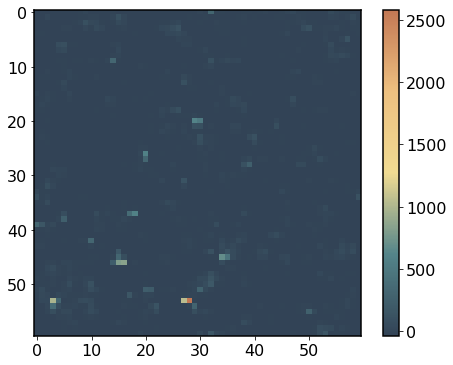

In [61]:
plt.imshow(CIImap_I[0], cmap=cmap)
plt.colorbar()


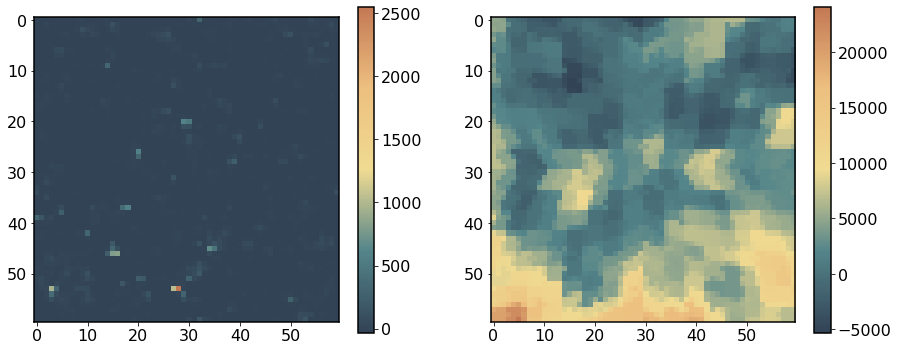

In [8]:
plt.figure(figsize=(15, 6))
plt.subplot(1,2,1)
plt.imshow(CIImap[0], cmap=cmap)
plt.colorbar()

plt.subplot(1,2,2)
plt.imshow(CIImap_gal[0], cmap=cmap)
plt.colorbar()

In [3]:
LC_CO=make_measurements(LC_params('CO'))
#ang_lim=1*u.deg
#LC_CO.update(RAObs_min=-ang_lim,RAObs_max=ang_lim, DECObs_min=-ang_lim,DECObs_max=ang_lim)

COmap_gal=np.asarray(LC_CO.obs_3d_map)

#kCO_gal=LC_CO.k_Pk_poles
#PkCO_0_gal=LC_CO.Pk_0
#PkCO_2_gal=LC_CO.Pk_2

#COmap_gal=np.load('../../map_foreground_CO_T.npy')
#kCO_gal,PkCO_0_gal,PkCO_2_gal=np.load('../../PkCO_foreground_T.npy')

/home/gsatopo1/data-mkamion1/MDPL2-UM-squareLC/lightcone_MDPL2UM_161.fits
/home/gsatopo1/data-mkamion1/MDPL2-UM-squareLC/lightcone_MDPL2UM_162.fits


/home/gsatopo1/library/py3_env/lib/python3.7/site-packages/healpy/fitsfunc.py:369: UserWarning: If you are not specifying the input dtype and using the default np.float64 dtype of read_map(), please consider that it will change in a future version to None as to keep the same dtype of the input file: please explicitly set the dtype if it is important to you.
  "If you are not specifying the input dtype and using the default "
/home/gsatopo1/library/py3_env/lib/python3.7/site-packages/healpy/fitsfunc.py:391: UserWarning: NSIDE = 2048
  warnings.warn("NSIDE = {0:d}".format(nside))
/home/gsatopo1/library/py3_env/lib/python3.7/site-packages/healpy/fitsfunc.py:400: UserWarning: ORDERING = RING in fits file
  warnings.warn("ORDERING = {0:s} in fits file".format(ordering))
/home/gsatopo1/library/py3_env/lib/python3.7/site-packages/healpy/fitsfunc.py:428: UserWarning: INDXSCHM = IMPLICIT
  warnings.warn("INDXSCHM = {0:s}".format(schm))
/home/gsatopo1/library/py3_env/lib/python3.7/site-packages/

In [4]:
#LC_CO=make_measurements(LC_params('CO'))
LC_CO.update(do_gal_foregrounds=False)
COmap=np.asarray(LC_CO.obs_3d_map)

#kCO=LC_CO.k_Pk_poles
#PkCO_0=LC_CO.Pk_0
#PkCO_2=LC_CO.Pk_2

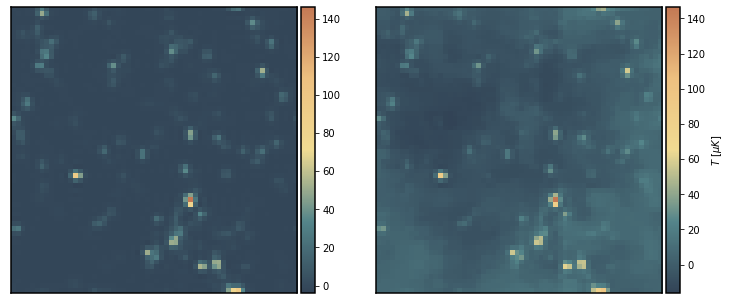

In [5]:
fig = plt.figure(figsize=(12, 6))
ax1 = fig.add_subplot(121)
im1 = ax1.imshow(COmap[0], cmap=cmap, interpolation='None')
ax1.set_xticks([])
ax1.set_yticks([])

divider = make_axes_locatable(ax1)
cax = divider.append_axes('right', size='5%', pad=0.05)

ax2 = fig.add_subplot(122)
im2 = ax2.imshow(COmap_gal[0], cmap=cmap, interpolation='None')
ax2.set_xticks([])
ax2.set_yticks([])

divider = make_axes_locatable(ax2)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im2, cax=cax, orientation='vertical', label=r"$T$ [$\mu K$]");

In [79]:
ralim=np.asarray([LC_CO.RAObs_min.value,LC_CO.RAObs_max.value])
declim=np.asarray([LC_CO.DECObs_min.value,LC_CO.DECObs_max.value])
z_plot=np.asarray([2.5,3.5])
ra,dec  = np.deg2rad(ralim),np.deg2rad(declim)
x = np.cos(dec) * np.cos(ra)
y = np.cos(dec) * np.sin(ra)
z = np.sin(dec)
pos_lims = np.vstack([x,y,z]).T

r = ((LC_CO.cosmo.comoving_radial_distance(z_plot)*u.Mpc).to(LC_CO.Mpch)).value
grid_lim = r[:,None]*pos_lims

x=np.linspace(0, grid_lim[1,1]- grid_lim[0,1], LC_CO.angular_supersample*LC_CO.Npixside[0])
y=np.linspace(0, grid_lim[1,2]-grid_lim[0,2], LC_CO.angular_supersample*LC_CO.Npixside[1])

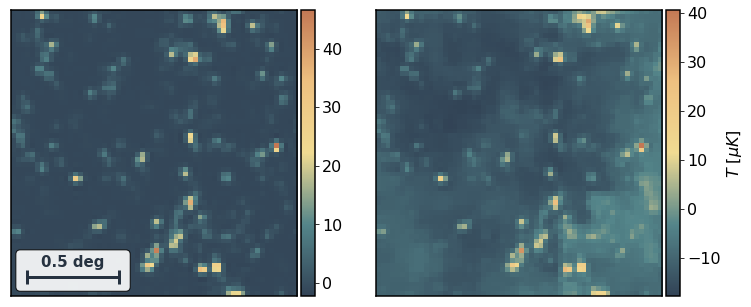

In [113]:
fig = plt.figure(figsize=(12, 6))
ax1 = fig.add_subplot(121)
im1 = ax1.imshow(COmap[0], cmap=cmap, interpolation='None')
ax1.set_xticks([])
ax1.set_yticks([])

divider = make_axes_locatable(ax1)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im1, cax=cax, orientation='vertical')

rside = x[-1]-x[0]
side = rside/16
cent = side+3
ax1.text(cent,57.5,'    0.5 deg    \n', color=grey,weight='bold',ha='center',va='bottom',fontsize=15,bbox=dict(boxstyle="round",facecolor='white', alpha=0.9))
ax1.errorbar(cent,55.5,xerr=side,marker='',ls='--',c=grey,elinewidth=3,capsize=7,capthick=3,zorder=10)


ax2 = fig.add_subplot(122)
im2 = ax2.imshow(COmap_gal[0], cmap=cmap, interpolation='None')
ax2.set_xticks([])
ax2.set_yticks([])

divider = make_axes_locatable(ax2)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im2, cax=cax, orientation='vertical', label=r"$T$ [$\mu K$]");

In [60]:
#TiCO_edge=np.logspace(-1, np.log10(np.max(COmap)), 50+1)
TiCO_edge=np.linspace(-4, 30, 30+1)
TiCO=(TiCO_edge[:-1]+TiCO_edge[1:])/2.

BiCO=np.histogram(COmap.flatten(), bins=TiCO_edge)[0]
BiCO_gal=np.histogram(COmap_gal.flatten(), bins=TiCO_edge)[0]

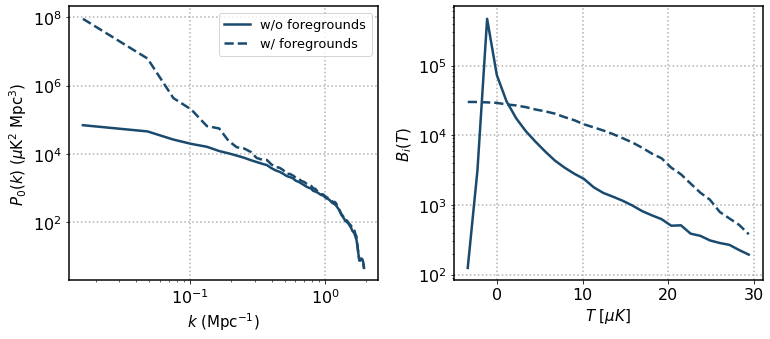

In [61]:
plt.figure(figsize=(11,5))
plt.subplot(1,2,1)
plt.loglog(kCO, PkCO_0, 'C0', label='w/o foregrounds')
plt.loglog(kCO_gal, PkCO_0_gal, '--C0', label='w/ foregrounds')
plt.xlabel("$k$ (Mpc$^{-1})$", fontsize = 15)
plt.ylabel("$P_0 (k)$ ($\mu$K$^2$ Mpc$^3$)", fontsize=15)
plt.grid(linestyle='dotted', lw=1.5)
plt.legend(fontsize=13)

plt.subplot(1,2,2)
plt.plot(TiCO, BiCO, 'C0')
plt.plot(TiCO, BiCO_gal, '--C0')
plt.yscale('log')
plt.xlabel(r"$T$ [$\mu K$]", fontsize = 15)
plt.ylabel("$B_{i}(T)$", fontsize=15)
plt.grid(linestyle='dotted', lw=1.5)
plt.tight_layout()

In [28]:
Lbox=LC_CO.Lbox.to(u.Mpc)
Nmesh=LC_CO.obs_3d_map.shape
kmax=np.pi*np.sqrt((Nmesh[0]/Lbox[0])**2 + (Nmesh[1]/Lbox[1])**2 + (Nmesh[2]/Lbox[2])**2)
kmax_par=np.pi*np.sqrt((Nmesh[0]/Lbox[0])**2)
kmax_perp=np.pi*np.sqrt((Nmesh[1]/Lbox[1])**2 + (Nmesh[2]/Lbox[2])**2)
print(kmax, kmax_par, kmax_perp)

1.3148752635320342 1 / Mpc 0.570012349494916 1 / Mpc 1.1848978352886472 1 / Mpc


In [40]:
index=5
print(LC_CO.k_Pk_poles[index].to(u.Mpc**-1))
print(LC_CO.Pk_2d.power['mu'][index])

0.11103668051447187 1 / Mpc
[-0.95560155 -0.84500938 -0.75432942 -0.64587137 -0.55605045 -0.46268014
 -0.32725813 -0.24401185 -0.14180448 -0.05788041  0.02894021  0.14180448
  0.24401185  0.32725813  0.46268014  0.55605045  0.64587137  0.75432942
  0.84500938  0.95560155]


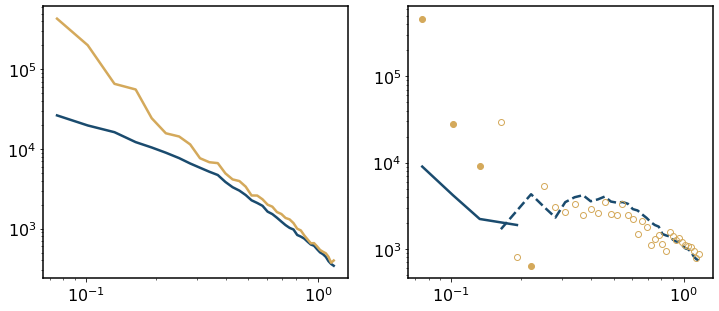

In [44]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.loglog(kCO[2:40], PkCO_0[2:40])
plt.loglog(kCO_gal[2:40], PkCO_0_gal[2:40])

plt.subplot(1,2,2)
plt.loglog(kCO[2:40][PkCO_2[2:40]>=0], PkCO_2[2:40][PkCO_2[2:40]>=0], 'C0')
plt.loglog(kCO[2:40][PkCO_2[2:40]<0], abs(PkCO_2[2:40][PkCO_2[2:40]<0]), '--C0')

plt.loglog(kCO_gal[2:40][PkCO_2_gal[2:40]>=0], PkCO_2_gal[2:40][PkCO_2_gal[2:40]>=0], 'oC1')
plt.loglog(kCO_gal[2:40][PkCO_2_gal[2:40]<0], abs(PkCO_2_gal[2:40][PkCO_2_gal[2:40]<0]), 'oC1', markerfacecolor='none')


In [62]:
def tp2ra(theta, phi):    
    ra = np.rad2deg(phi)
    dec = np.rad2deg(0.5 * np.pi - theta)
    return ra, dec

def observed_mask_2d(nside, ra_min, ra_max, dec_min, dec_max):
    pix = np.arange(hp.nside2npix(nside), dtype=int)
    theta, phi = hp.pix2ang(nside, pix)
    ra, dec = tp2ra(theta, phi)

    DEC_mask=(dec>dec_min)&(dec<=dec_max)
    ra[ra>180]=ra[ra>180]-360
    RA_mask=(ra>ra_min)&(ra<=ra_max)

    mask=RA_mask&DEC_mask
    return mask

nside = 2**11
map_dist = pysm3.MapDistribution(pixel_indices=None, nside=nside, mpi_comm=MPI.COMM_WORLD)
sky = pysm3.Sky(nside=nside, preset_strings=["d1", "s1", "f1", "a1"], map_dist=map_dist)

galmap_CO=(sky.get_emission(29*u.GHz)[0])*u.uK
galmap_CII=(sky.get_emission(273*u.GHz)[0])*u.uK#.to(u.Jy/u.sr, equivalencies=u.brightness_temperature(273*u.GHz))

/home/gsatopo1/library/py3_env/lib/python3.7/site-packages/healpy/fitsfunc.py:391: UserWarning: NSIDE = 512
  warnings.warn("NSIDE = {0:d}".format(nside))
/home/gsatopo1/library/py3_env/lib/python3.7/site-packages/healpy/fitsfunc.py:400: UserWarning: ORDERING = RING in fits file
  warnings.warn("ORDERING = {0:s} in fits file".format(ordering))
/home/gsatopo1/library/py3_env/lib/python3.7/site-packages/healpy/fitsfunc.py:428: UserWarning: INDXSCHM = IMPLICIT
  warnings.warn("INDXSCHM = {0:s}".format(schm))


In [63]:
proj=hp.projector.CartesianProj(rot=[0, -90], xsize=60, lonra =  [-1, 1], latra=[-1, 1])

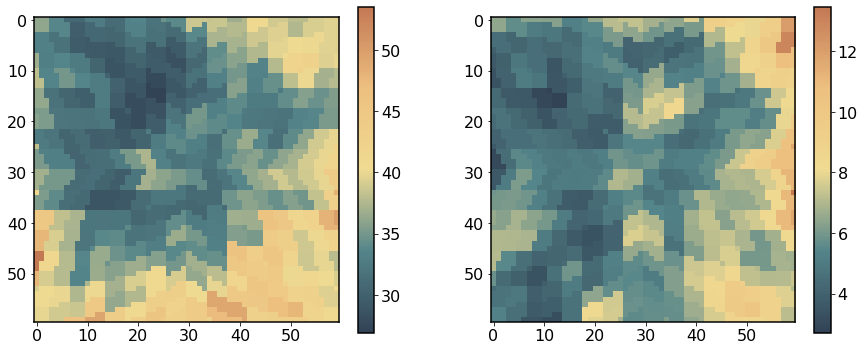

In [64]:
def func(x1, x2, x3):
    return hp.vec2pix(2**11, x1, x2, x3)

cartesian_CO=proj.projmap(galmap_CO, func)
cartesian_CII=proj.projmap(galmap_CII, func)

plt.figure(figsize=(15, 6))
plt.subplot(1,2,1)
plt.imshow(cartesian_CO, cmap=cmap)
plt.colorbar()

plt.subplot(1,2,2)
plt.imshow(cartesian_CII, cmap=cmap)
plt.colorbar()